# Cifar 100 Dataset: Testing different CovNet Architectures

There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

Here is the list of classes in the CIFAR-100:

https://www.cs.toronto.edu/~kriz/cifar.html

In [5]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
%matplotlib inline
import matplotlib.pyplot as plt
import random
import sklearn.model_selection
import os
slim = tf.contrib.slim

### Cifar Dataset Import

Loaded in this way, each of the batch files contains a dictionary with the following elements:

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [6]:
#imports data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


# Load the raw CIFAR-100 data.
cifar100_test = unpickle('/mnt/Data/Datasets/cifar-100-python/test')
cifar100_train = unpickle('/mnt/Data/Datasets/cifar-100-python/train')
labelMap = unpickle('/mnt/Data/Datasets/cifar-100-python/meta')
#tr for training data and te for testing data, X is data, Y is label
X_train = cifar100_train[b'data']
Y_train = np.array(cifar100_train[b'fine_labels'])
X_test = cifar100_test[b'data']
Y_test = np.array(cifar100_test[b'fine_labels'])

#Reshape the structure get intensity values between 0 and 1
X_train = np.reshape(X_train,(-1,3, 32, 32))
X_train=np.transpose(X_train,[0,2,3,1]).astype(np.float32)/256
X_test = np.reshape(X_test,(-1,3, 32, 32))
X_test=np.transpose(X_test,[0,2,3,1]).astype(np.float32)/256


Y_train=(np.arange(100) == Y_train[:,None]).astype(np.float32)
Y_test=(np.arange(100) == Y_test[:,None]).astype(np.float32)


X_train,X_val,Y_train,Y_val=sklearn.model_selection.train_test_split(X_train,Y_train,test_size=0.10, random_state=42)



### Visualise few of the Images

Sample Training Images


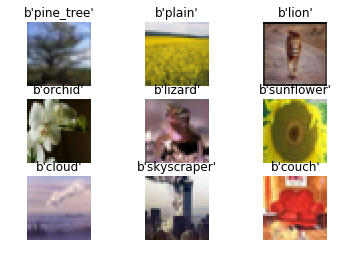

In [7]:
print('Sample Training Images')
for i in range(1,10):
        plt.subplot(3,3,i)
        plt.axis("off")
        r=random.randint(0,X_train.shape[0])
        plt.imshow(X_train[r])
        plt.title(labelMap[b'fine_label_names'][np.argmax(Y_train[r])])
plt.show()

In [8]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

### LeNet 5 CovNet Architecture

Stacks of convolutional layer and max pooling layer followed by a fully connected layer. The output is a softmax over all the output classes. We will not use any regularization in these 

In [86]:
batch_size = 512
num_channels=3
patch_size = 5
depth = 32


num_hidden = 1024
image_size=32
num_labels=100
graph = tf.Graph()

with graph.as_default(): 

  # Input data.
 
  dataset = tf.placeholder(
    tf.float32, shape=(None, image_size, image_size, num_channels))
  labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  keep_prob=tf.placeholder_with_default(1.0,())

  global_step = tf.Variable(0, trainable=False)
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.constant(0.0, shape=[depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(0.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size//4 * image_size  //4* depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(0.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(0.0, shape=[num_labels]))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool=tf.nn.max_pool(hidden,[1,2,2,1],[1,2,2,1],padding='SAME')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool=tf.nn.max_pool(hidden,[1,2,2,1],[1,2,2,1],padding='SAME')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [tf.shape(pool)[0], shape[1] * shape[2] * shape[3]])
    drop=tf.nn.dropout(reshape,keep_prob=keep_prob)
    hidden = tf.nn.relu(tf.matmul(drop, layer3_weights) + layer3_biases)
    drop=tf.nn.dropout(hidden,keep_prob=keep_prob)
    #hidden=tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return (tf.matmul(drop, layer4_weights) + layer4_biases)
  
  # Training computation.
  logits = model(dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  # Predictions for the training, validation, and test data.
  predict = tf.nn.softmax(logits)

In [76]:
num_steps = 5000
batch_size=512
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  saver = tf.train.Saver()
  saver.restore(session, "lenet5.ckpt")
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (X_train.shape[0] - batch_size)
    batch_data =X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = Y_train[offset:(offset + batch_size), :]
    feed_dict = {dataset : batch_data, labels : batch_labels,keep_prob:0.5}
    _, l, predictions = session.run(
      [optimizer, loss, predict], feed_dict=feed_dict)
    if (step % 100== 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %f%%' % accuracy(predictions, batch_labels))
      print('Val accuracy: %f%%' % accuracy(predict.eval(feed_dict={dataset:X_val,labels: Y_val,keep_prob:1.0}),Y_val))
    if((step+1)%1000==0):
        save_path = saver.save(session, "lenet5.ckpt")
        print('Model Saved')


INFO:tensorflow:Restoring parameters from lenet5.ckpt
Initialized
Minibatch loss at step 0: 2.158313
Minibatch accuracy: 44.921875%
Val accuracy: 41.220000%
Minibatch loss at step 100: 1.551770
Minibatch accuracy: 55.273438%
Val accuracy: 41.600000%
Minibatch loss at step 200: 1.474938
Minibatch accuracy: 56.445312%
Val accuracy: 41.240000%
Minibatch loss at step 300: 1.607974
Minibatch accuracy: 55.273438%
Val accuracy: 41.400000%
Minibatch loss at step 400: 1.612716
Minibatch accuracy: 55.859375%
Val accuracy: 41.620000%
Minibatch loss at step 500: 1.457973
Minibatch accuracy: 57.812500%
Val accuracy: 41.800000%
Minibatch loss at step 600: 1.656533
Minibatch accuracy: 55.664062%
Val accuracy: 40.940000%
Minibatch loss at step 700: 1.417086
Minibatch accuracy: 58.007812%
Val accuracy: 41.840000%
Minibatch loss at step 800: 1.477924
Minibatch accuracy: 62.890625%
Val accuracy: 41.620000%
Minibatch loss at step 900: 1.377769
Minibatch accuracy: 60.156250%
Val accuracy: 41.220000%
Model 

In [87]:

with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, "lenet5.ckpt")
    offset=0
    iters=X_test.shape[0]//batch_size
    s=0
    for i in range(iters):
        preds=predict.eval(feed_dict={dataset:X_test[offset:offset+batch_size],labels: Y_test[offset:offset+batch_size],keep_prob:1.0})
        s=s+np.sum(np.argmax(preds, 1) == np.argmax(Y_test[offset:offset+batch_size], 1))
        offset=offset+batch_size
    acc=(s/X_test.shape[0])*100
    print('Test accuracy: %f%%' % acc)

INFO:tensorflow:Restoring parameters from lenet5.ckpt
Test accuracy: 40.800000%


### 1x1 Convolutions

Stacks of convolutional layer, 1x1 convolutions and max pooling layer followed by a fully connected layer. The output is a softmax over all the output classes. We will not use any regularization in these 

In [78]:
batch_size = 100
num_channels=3
patch_size = 5
depth = 64


num_hidden = 1000
image_size=32
num_labels=100
graph2 = tf.Graph()

with graph2.as_default(): 

  # Input data.
 
  dataset = tf.placeholder(
    tf.float32, shape=(None, image_size, image_size, num_channels))
  labels = tf.placeholder(tf.float32, shape=(None, num_labels))
  keep_prob=tf.placeholder_with_default(1.0,())

  global_step = tf.Variable(0, trainable=False)
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_inner_weights = tf.Variable(tf.truncated_normal(
      [1, 1, depth, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.truncated_normal(
      [depth], stddev=0.1))
  layer1_inner_biases = tf.Variable(tf.truncated_normal(
      [depth], stddev=0.1))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_inner_weights = tf.Variable(tf.truncated_normal(
      [1, 1, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.truncated_normal(
      [ depth], stddev=0.1))
  layer2_inner_biases = tf.Variable(tf.truncated_normal(
      [depth], stddev=0.1))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size//4 * image_size  //4* depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.truncated_normal(
      [num_hidden], stddev=0.1))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.truncated_normal(
      [num_labels], stddev=0.1))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv=tf.nn.conv2d(hidden, layer1_inner_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_inner_biases)
    pool=tf.nn.avg_pool(hidden,[1,2,2,1],[1,2,2,1],padding='SAME')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    conv=tf.nn.conv2d(hidden, layer2_inner_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_inner_biases)
    pool=tf.nn.avg_pool(hidden,[1,2,2,1],[1,2,2,1],padding='SAME')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [tf.shape(pool)[0], shape[1] * shape[2] * shape[3]])
    drop=tf.nn.dropout(reshape,keep_prob=keep_prob)
    hidden = tf.nn.relu(tf.matmul(drop, layer3_weights) + layer3_biases)
    drop=tf.nn.dropout(hidden,keep_prob=keep_prob)
    #hidden=tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return (tf.matmul(drop, layer4_weights) + layer4_biases)
  
  # Training computation.
  logits = model(dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  # Predictions for the training, validation, and test data.
  predict = tf.nn.softmax(logits)

In [83]:
num_steps = 5000
batch_size=100
with tf.Session(graph=graph2) as session:
  tf.global_variables_initializer().run()
  saver = tf.train.Saver()
  saver.restore(session, "1x1.ckpt")
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (X_train.shape[0] - batch_size)
    batch_data =X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = Y_train[offset:(offset + batch_size), :]
    feed_dict = {dataset : batch_data, labels : batch_labels,keep_prob:0.5}
    _, l, predictions = session.run(
      [optimizer, loss, predict], feed_dict=feed_dict)
    if (step % 100== 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %f%%' % accuracy(predictions, batch_labels))
      print('Val accuracy: %f%%' % accuracy(predict.eval(feed_dict={dataset:X_val,labels: Y_val,keep_prob:1.0}),Y_val))
    if((step+1)%1000==0):
        save_path = saver.save(session, "1x1.ckpt")
        print('Model Saved')


INFO:tensorflow:Restoring parameters from 1x1.ckpt
Initialized
Minibatch loss at step 0: 3.241354
Minibatch accuracy: 35.000000%
Val accuracy: 42.720000%
Minibatch loss at step 100: 1.110763
Minibatch accuracy: 64.000000%
Val accuracy: 41.540000%
Minibatch loss at step 200: 1.016511
Minibatch accuracy: 72.000000%
Val accuracy: 41.540000%
Minibatch loss at step 300: 1.035814
Minibatch accuracy: 71.000000%
Val accuracy: 41.680000%
Minibatch loss at step 400: 1.102659
Minibatch accuracy: 72.000000%
Val accuracy: 40.700000%
Minibatch loss at step 500: 1.151255
Minibatch accuracy: 67.000000%
Val accuracy: 41.840000%
Minibatch loss at step 600: 1.125694
Minibatch accuracy: 61.000000%
Val accuracy: 41.620000%
Minibatch loss at step 700: 1.276934
Minibatch accuracy: 62.000000%
Val accuracy: 41.620000%
Minibatch loss at step 800: 1.183647
Minibatch accuracy: 69.000000%
Val accuracy: 42.040000%
Minibatch loss at step 900: 1.216254
Minibatch accuracy: 68.000000%
Val accuracy: 42.580000%
Model Sav

In [84]:

with tf.Session(graph=graph2) as session:
    saver = tf.train.Saver()
    saver.restore(session, "1x1.ckpt")
    offset=0
    iters=X_test.shape[0]//batch_size
    s=0
    for i in range(iters):
        preds=predict.eval(feed_dict={dataset:X_test[offset:offset+batch_size],labels: Y_test[offset:offset+batch_size],keep_prob:1.0})
        s=s+np.sum(np.argmax(preds, 1) == np.argmax(Y_test[offset:offset+batch_size], 1))
        offset=offset+batch_size
    acc=(s/X_test.shape[0])*100
    print('Test accuracy: %f%%' % acc)

INFO:tensorflow:Restoring parameters from 1x1.ckpt
Test accuracy: 43.150000%


### CifarNet

In [25]:
from nets import cifarnet

In [26]:
graph3 = tf.Graph()
batch_size = 100
num_channels=3
patch_size = 5
depth = 64


num_hidden = 1000
image_size=32
num_labels=100
with graph3.as_default():
    dataset = tf.placeholder(
        tf.float32, shape=(None, image_size, image_size, num_channels))
    labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    is_training=tf.placeholder(tf.bool)

    def model(data):
        with slim.arg_scope(cifarnet.cifarnet_arg_scope()):
            logits,endpts=cifarnet.cifarnet(data,100,is_training=is_training)
        return logits
    logits = model(dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  # Predictions for the training, validation, and test data.
    predict = tf.nn.softmax(logits)

In [28]:
num_steps = 5000
batch_size=100
with tf.Session(graph=graph3) as session:
  tf.global_variables_initializer().run()
  saver = tf.train.Saver()
  saver.restore(session, "resnet_50.ckpt")
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (X_train.shape[0] - batch_size)
    batch_data =X_train[offset:(offset + batch_size), :, :, :]
    batch_labels = Y_train[offset:(offset + batch_size), :]
    feed_dict = {dataset : batch_data, labels : batch_labels,is_training:True}
    _, l, predictions = session.run(
      [optimizer, loss, predict], feed_dict=feed_dict)
    if (step % 100== 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %f%%' % accuracy(predictions, batch_labels))
      print('Val accuracy: %f%%' % accuracy(predict.eval(feed_dict={dataset:X_val,labels: Y_val,is_training:False}),Y_val))
    if((step+1)%1000==0):
        save_path = saver.save(session, "resnet_50.ckpt")
        print('Model Saved')


INFO:tensorflow:Restoring parameters from resnet_50.ckpt
Initialized
Minibatch loss at step 0: 1.930902
Minibatch accuracy: 46.000000%
Val accuracy: 38.200000%
Minibatch loss at step 100: 2.109289
Minibatch accuracy: 43.000000%
Val accuracy: 38.060000%
Minibatch loss at step 200: 1.858162
Minibatch accuracy: 49.000000%
Val accuracy: 36.940000%
Minibatch loss at step 300: 1.854408
Minibatch accuracy: 46.000000%
Val accuracy: 37.420000%
Minibatch loss at step 400: 1.715372
Minibatch accuracy: 57.000000%
Val accuracy: 38.000000%
Minibatch loss at step 500: 1.921619
Minibatch accuracy: 44.000000%
Val accuracy: 38.100000%
Minibatch loss at step 600: 1.661600
Minibatch accuracy: 54.000000%
Val accuracy: 38.180000%
Minibatch loss at step 700: 1.775340
Minibatch accuracy: 48.000000%
Val accuracy: 37.960000%
Minibatch loss at step 800: 1.444199
Minibatch accuracy: 53.000000%
Val accuracy: 37.980000%
Minibatch loss at step 900: 1.797954
Minibatch accuracy: 46.000000%
Val accuracy: 37.660000%
Mod

In [31]:

with tf.Session(graph=graph3) as session:
    saver = tf.train.Saver()
    saver.restore(session, "resnet_50.ckpt")
    offset=0
    iters=X_test.shape[0]//batch_size
    s=0
    for i in range(iters):
        preds=predict.eval(feed_dict={dataset:X_test[offset:offset+batch_size],labels: Y_test[offset:offset+batch_size],is_training:False})
        s=s+np.sum(np.argmax(preds, 1) == np.argmax(Y_test[offset:offset+batch_size], 1))
        offset=offset+batch_size
    acc=(s/X_test.shape[0])*100
    print('Test accuracy: %f%%' % acc)

INFO:tensorflow:Restoring parameters from resnet_50.ckpt
Test accuracy: 37.310000%
